# **Turbo Spin Echo (TSE) Sequence for T2 Mapping**
---
**About:** This notebook creates a 2D multi-slice Turbo Spin Echo (TSE) MRI sequence using the `pypulseq` library. This sequence is for T2 mapping using multiple echoes each TR at different echo times. The signal is ordered first by echo time, then by phase encodes, and last by slice. All input echo times are attempted to be fit into one TR.

---
## Contents
1. Install & import packages
2. Set system limits and acquisition parameters
3. Calculate sequence components
4. Add building blocks to sequence
5. Examine sequence
6. Export sequence as .seq file

# 1. Install & import packages
Pypulseq (https://github.com/imr-framework/pypulseq) is used to generate the .seq format file. See [1] in references for more information about the Pulseq specification.

In [1]:
#!pip install git+https://github.com/imr-framework/pypulseq.git@1.2.0post4
!pip show pypulseq || pip install pypulseq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.1/233.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 9.2 MB/s eta 0:00:00


Pypulseq, numpy, and plotting functions are imported.
**Run the following code cell twice** to eliminate errors.


In [2]:
# Import functions
import copy
from math import pi
import math
import warnings
import numpy as np
np.float = float
np.complex = complex
import pypulseq as pp
#from pypulseq.Sequence.sequence import Sequence
#from pypulseq.calc_duration import calc_duration
#from pypulseq.make_adc import make_adc
# from pypulseq.make_delay import make_delay
# from pypulseq.make_sinc_pulse import make_sinc_pulse
# from pypulseq.make_trap_pulse import make_trapezoid
# from pypulseq.opts import Opts
# from pypulseq.calc_rf_center import calc_rf_center
# from pypulseq.make_extended_trapezoid import make_extended_trapezoid
from scipy.io import savemat

import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


# 2. Set system limits and acquisition parameters

  


  

## System limits & setup
System limits are specific to the MR scanner. The provided limits are
compatible with a Siemens Prisma 3T scanner.  

In [3]:
# Set system limits
ramp_time = 250e-6 # Ramp up/down time for all gradients where this is specified
system = pp.Opts(max_grad=32, grad_unit='mT/m', max_slew=130,
                  slew_unit='T/m/s', rf_ringdown_time=100e-6, # changed from 30e-6
                  rf_dead_time=100e-6, adc_dead_time=20e-6)

# Initialize sequence
seq = pp.Sequence(system=system)
# Set the gyromagnetic ratio constant for protons
GAMMA_BAR = 42.5775e6

## Acquisition parameters (geometry)
* All distance values are in meters
* This sequences acquires slices in the order they are listed; slice_locs indicate the slice locations relative to isocenter on the slice-selecting axis

In [4]:
# FOV, matrix size
fov = 0.250  # in meters
n = 128  # matrix size isotropic

# Spatial encoding directions
# Sagittal!
ch_ro = 'x'
ch_pe = 'y'
ch_ss = 'z'

# Slice selection (meters)
n_slices = 1
thk = 6e-3
slice_locs = [0]

# Derived parameters
Nf, Np = (n, n)
delta_k = 1 / fov
k_width = Nf * delta_k

## Acquisition parameters (contrast)
* Set flip angle (FA), inversion time (TI), repetition time (TR), and echo time (TE) here to set the target contrast


In [5]:

# Flip angle
fa = 90  #degrees
# Timing (s)
TR = 4.5 # Repetition time
#TEs = 1e-3 * np.array([9, 12, 15, 20, 25, 30, 40, 45, 50, 60, 75, 80, 100, 120, 160]) # Echo time
#TE = TEs[0]
TE = 7e-3
# Number of echoes per excitation (i.e. turbo factor)
n_echo = 23
print(f"{n_echo} echoes per TR are needed")

23 echoes per TR are needed


## Acquisition parameters (others)





In [6]:
# Readout duration
readout_time = 3.2e-3 + 2 * system.adc_dead_time

# Excitation pulse duration
t_ex = 2.5e-3
t_exwd = t_ex + system.rf_ringdown_time + system.rf_dead_time

# Refocusing pulse duration
t_ref = 2e-3
t_refwd = t_ref + system.rf_ringdown_time + system.rf_dead_time

# Time gaps for spoilers
t_sp = 0.5 * (TE - readout_time - t_refwd) # time gap between pi-pulse and readout
t_spex = 0.5 * (TE - t_exwd - t_refwd) # time gap between pi/2-pulse and pi-pulse

# Spoiling factors
fsp_r = 1 # in readout direction per refocusing
fsp_s = 0.5 # in slice direction per refocusing


# 3. Calculate sequence components



## Slice-selective RF pulses & gradient
* RF pulses with zero frequency shift are created. The frequency is then changed before adding the pulses to sequence blocks for each slice.
* Two unique RF pulses are generated:
  - $\alpha$-pulse (flip into x-y plane)
  - 180-degree pulse (refocusing)



In [7]:

# 90 deg pulse (+y')
rf_ex_phase = np.pi / 2
flip_ex = fa * np.pi / 180
# rf_ex, g_ss, _ = pp.make_sinc_pulse(flip_angle=flip_ex, system=system, duration=t_ex,
#                                     slice_thickness=thk, apodization=0.5, time_bw_product=4, phase_offset=rf_ex_phase)
rf_ex, g_ss, _ = pp.make_sinc_pulse(
    flip_angle=flip_ex,
    duration=t_ex,
    slice_thickness=thk,
    apodization=0.5,
    time_bw_product=4,
    phase_offset=rf_ex_phase,
    system=system,
    return_gz=True
)
gs_ex = pp.make_trapezoid(channel=ch_ss, system=system, amplitude=g_ss.amplitude, flat_time=t_exwd, rise_time=ramp_time)


# 180 deg pulse (+x')
rf_ref_phase = 0
flip_ref = 180 * np.pi / 180
# rf_ref, gz, _ = pp.make_sinc_pulse(flip_angle=flip_ref, system=system, duration=t_ref, slice_thickness=thk,
#                                 apodization=0.5, time_bw_product=4, phase_offset=rf_ref_phase, use='refocusing')
rf_ref, gz, _ = pp.make_sinc_pulse(
    flip_angle=flip_ref,
    duration=t_ref,
    slice_thickness=thk,
    apodization=0.5,
    time_bw_product=4,
    phase_offset=rf_ref_phase,
    use='refocusing',
    system=system,
    return_gz=True
)
gs_ref = pp.make_trapezoid(channel=ch_ss, system=system, amplitude=gs_ex.amplitude, flat_time=t_refwd, rise_time=ramp_time)


## Make gradients and ADC
* gs_spex : slice direction spoiler between initial excitation and 1st 180 pulse
* gs_spr : slice direction spoiler between 180 pulses
* gr_spr : readout direction spoiler; area is (fsp_r) x (full readout area)


In [8]:
# SS spoiling
ags_ex = gs_ex.area / 2
gs_spr = pp.make_trapezoid(channel=ch_ss, system=system, area=ags_ex * (1 + fsp_s), duration=t_sp, rise_time=ramp_time)
gs_spex = pp.make_trapezoid(channel=ch_ss, system=system, area=ags_ex * fsp_s, duration=t_spex, rise_time=ramp_time)

# Readout gradient and ADC
gr_acq = pp.make_trapezoid(channel=ch_ro, system=system, flat_area=k_width, flat_time=readout_time, rise_time=ramp_time)

# No need for risetime delay since it is set at beginning of flattime; delay is ADC deadtime
adc = pp.make_adc(num_samples=Nf, duration=gr_acq.flat_time - 40e-6, delay=20e-6)

# RO spoiling
gr_spr = pp.make_trapezoid(channel=ch_ro, system=system, area=gr_acq.area * fsp_r, duration=t_sp, rise_time=ramp_time)

# Following is not used anywhere
# gr_spex = make_trapezoid(channel=ch_ro, system=system, area=gr_acq.area * (1 + fsp_r), duration=t_spex, rise_time=ramp_time)


# Prephasing gradient in RO direction
agr_preph = gr_acq.area / 2 + gr_spr.area
gr_preph = pp.make_trapezoid(channel=ch_ro, system=system, area=agr_preph, duration=t_spex, rise_time=ramp_time)

## **Phase encoding areas**
Sequential; same one is used for each TR (with multiple readouts at different TEs)

In [9]:
# Phase encoding lobe calculations
# Simple sequential PE (same one for all readouts in each TR)
pe_steps = np.arange(0, Np) - 0.5 * Np
phase_areas = pe_steps * delta_k
print(phase_areas)

[-256. -252. -248. -244. -240. -236. -232. -228. -224. -220. -216. -212.
 -208. -204. -200. -196. -192. -188. -184. -180. -176. -172. -168. -164.
 -160. -156. -152. -148. -144. -140. -136. -132. -128. -124. -120. -116.
 -112. -108. -104. -100.  -96.  -92.  -88.  -84.  -80.  -76.  -72.  -68.
  -64.  -60.  -56.  -52.  -48.  -44.  -40.  -36.  -32.  -28.  -24.  -20.
  -16.  -12.   -8.   -4.    0.    4.    8.   12.   16.   20.   24.   28.
   32.   36.   40.   44.   48.   52.   56.   60.   64.   68.   72.   76.
   80.   84.   88.   92.   96.  100.  104.  108.  112.  116.  120.  124.
  128.  132.  136.  140.  144.  148.  152.  156.  160.  164.  168.  172.
  176.  180.  184.  188.  192.  196.  200.  204.  208.  212.  216.  220.
  224.  228.  232.  236.  240.  244.  248.  252.]


## Split gradients

In [10]:
# Split gradients and recombine into blocks

# gs1 : ramp up of gs_ex
gs1_times = [0, gs_ex.rise_time]
gs1_amp = [0, gs_ex.amplitude]
gs1 = pp.make_extended_trapezoid(channel=ch_ss, times=gs1_times, amplitudes=gs1_amp)

# gs2 : flat part of gs_ex
gs2_times = [0, gs_ex.flat_time]
gs2_amp = [gs_ex.amplitude, gs_ex.amplitude]
gs2 = pp.make_extended_trapezoid(channel=ch_ss, times=gs2_times, amplitudes=gs2_amp)

# gs3 : Bridged slice pre-spoiler
gs3_times = [0, gs_spex.rise_time, gs_spex.rise_time + gs_spex.flat_time,
             gs_spex.rise_time + gs_spex.flat_time + gs_spex.fall_time]
gs3_amp = [gs_ex.amplitude, gs_spex.amplitude, gs_spex.amplitude, gs_ref.amplitude]
gs3 = pp.make_extended_trapezoid(channel=ch_ss, times=gs3_times, amplitudes=gs3_amp)


# gs4 : Flat slice selector for pi-pulse
gs4_times = [0, gs_ref.flat_time]
gs4_amp = [gs_ref.amplitude, gs_ref.amplitude]
gs4 = pp.make_extended_trapezoid(channel=ch_ss, times=gs4_times, amplitudes=gs4_amp)

# gs5 : Bridged slice post-spoiler
gs5_times = [0, gs_spr.rise_time, gs_spr.rise_time + gs_spr.flat_time,
             gs_spr.rise_time + gs_spr.flat_time + gs_spr.fall_time]
gs5_amp = [gs_ref.amplitude, gs_spr.amplitude, gs_spr.amplitude, 0]
gs5 = pp.make_extended_trapezoid(channel=ch_ss, times=gs5_times, amplitudes=gs5_amp)



# gs7 : The gs3 for next pi-pulse
gs7_times = [0, gs_spr.rise_time, gs_spr.rise_time + gs_spr.flat_time,
             gs_spr.rise_time + gs_spr.flat_time + gs_spr.fall_time]
gs7_amp = [0, gs_spr.amplitude, gs_spr.amplitude, gs_ref.amplitude]
gs7 = pp.make_extended_trapezoid(channel=ch_ss, times=gs7_times, amplitudes=gs7_amp)


# gr3 : pre-readout gradient
gr3 = gr_preph


# gr5 : Readout post-spoiler
gr5_times = [0, gr_spr.rise_time, gr_spr.rise_time + gr_spr.flat_time,
             gr_spr.rise_time + gr_spr.flat_time + gr_spr.fall_time]
gr5_amp = [0, gr_spr.amplitude, gr_spr.amplitude, gr_acq.amplitude]
gr5 = pp.make_extended_trapezoid(channel=ch_ro, times=gr5_times, amplitudes=gr5_amp)


# gr6 : Flat readout gradient
gr6_times = [0, readout_time]
gr6_amp = [gr_acq.amplitude, gr_acq.amplitude]
gr6 = pp.make_extended_trapezoid(channel=ch_ro, times=gr6_times, amplitudes=gr6_amp)


# gr7 : the gr3 for next repeat
gr7_times = [0, gr_spr.rise_time, gr_spr.rise_time + gr_spr.flat_time,
             gr_spr.rise_time + gr_spr.flat_time + gr_spr.fall_time]
gr7_amp = [gr_acq.amplitude, gr_spr.amplitude, gr_spr.amplitude, 0]
gr7 = pp.make_extended_trapezoid(channel=ch_ro, times=gr7_times, amplitudes=gr7_amp)

## Timing (delay) calculations

In [11]:
# delay_TR : delay at the end of each TSE pulse train (i.e. each TR)
t_ex = gs1.tt[-1] + gs2.tt[-1] + gs3.tt[-1]
t_ref = gs4.tt[-1] + gs5.tt[-1] + gs7.tt[-1] + readout_time
t_end = gs4.tt[-1] + gs5.tt[-1]
TE_train = t_ex + n_echo * t_ref + t_end
TR_fill = TR - TE_train
TR_fill = system.grad_raster_time * round(TR_fill / system.grad_raster_time)
if TR_fill < 0:
    TR_fill = 1e-3
    warnings.warn(f'TR too short, adapted to include all slices to: {1000 * n_slices * (TE_train + TR_fill)} ms')
else:
    print(f'TR fill: {1000 * TR_fill} ms')
delay_TR = pp.make_delay(TR_fill)



TR fill: 4332.02 ms


# 4. Add building blocks to sequence

In [12]:

adc_count = 0
for s in range(n_slices): # For each slice (not interleaved!!)
  slice_loc = slice_locs[s]
  #rf_ex.freq_offset = gs_ex.amplitude * thk * (s - (n_slices - 1) / 2)
  #rf_ref.freq_offset = gs_ref.amplitude * thk * (s - (n_slices - 1) / 2)
  rf_ex.freq_offset = gs_ex.amplitude * slice_loc
  rf_ref.freq_offset = gs_ref.amplitude * slice_loc
  rf_ex.phase_offset = rf_ex_phase - 2 * np.pi * rf_ex.freq_offset * pp.calc_rf_center(rf_ex)[0]
  rf_ref.phase_offset = rf_ref_phase - 2 * np.pi * rf_ref.freq_offset * pp.calc_rf_center(rf_ref)[0]



  for k_ex in range(Np + 1): # For each TR

      if k_ex > 0:
          phase_area = phase_areas[k_ex - 1]
          print(phase_area)
      else:
          # First TR is skipped so zero phase encoding is needed
          phase_area = 0.0  # 0.0 and not 0 because -phase_area should successfully result in negative zero

      # Make phase encoding gradients (they are reused for all readouts)
      gp_pre = pp.make_trapezoid(channel=ch_pe, system=system, area=phase_area, duration=t_sp, rise_time=ramp_time)
      gp_rew = pp.make_trapezoid(channel=ch_pe, system=system, area=-phase_area, duration=t_sp, rise_time=ramp_time)


      seq.add_block(gs1)
      seq.add_block(gs2, rf_ex) # make sure gs2 has channel ch_ss
      seq.add_block(gs3, gr3)

      # Start turbo encoding
      for r in range(n_echo): # For each TE we want to measure
          seq.add_block(gs4, rf_ref)
          seq.add_block(gs5, gr5, gp_pre)
          # Skipping first TR
          if k_ex > 0:
              print(adc_count)
              adc_count += 1
              seq.add_block(gr6, adc)
          else:
              seq.add_block(gr6)
          seq.add_block(gs7, gr7, gp_rew)

      seq.add_block(gs4)
      seq.add_block(gs5)
      seq.add_block(delay_TR)



-256.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
-252.0
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
-248.0
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
-244.0
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
-240.0
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
-236.0
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
-232.0
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
-228.0
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
-224.0
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
-220.0
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
-216.0
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
-212.0
253
254
255
25

# 5. Examine sequence



## Plot sequence

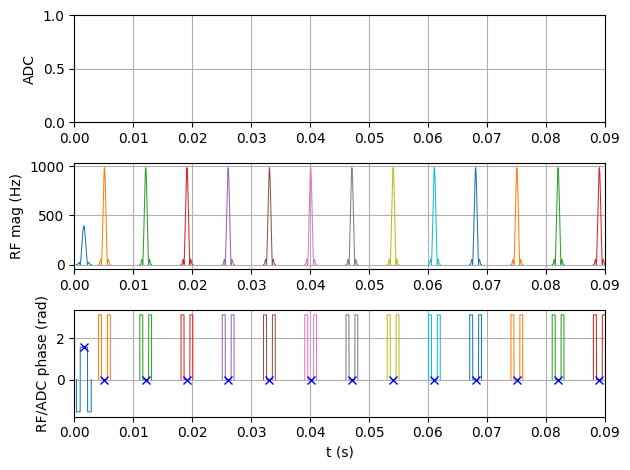

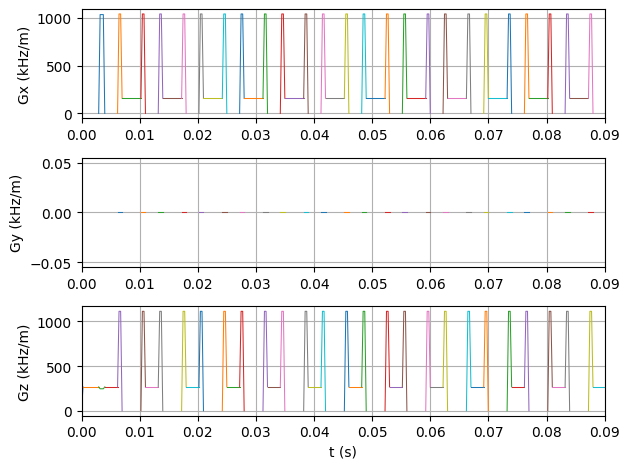

In [13]:
# Use inbuilt seq.plot method to see all waveforms (RF pulses, Gx, Gy, Gz, ADC)
#plt.tight_layout()
seq.plot(time_range=[0, 0.02*TR])

## Print sequence summary
This cell generates a detailed header for the sequence. It takes about 3 minutes to run with the default parameters.


In [14]:
# print(seq.test_report())

# 6. Export sequence as .seq file

THe following cell writes the sequence into a .seq file and initiates its download from the browser.

In [15]:
# Make copy of seq for writing to file
seq.set_definition('FOV', [fov, fov, thk]);
seq.set_definition('SlicePositions', 0);
seq.set_definition('SliceThickness', thk);
seq.set_definition('SliceGap', 0);
from google.colab import files
# The copy is needed because seq.write changes numerical data within the seq object for unit conversion
#seq_name = f"irse_ms_N{n}_Ns{ns_per_TR}_TI{int(TI*1000)}_TE{int(TE*1000)}_TR{int(TR*1000)}_FA{int(fa)}deg_dwell-10us.seq"
seq_name = f"tse_multiecho_t2_sag_neg12mm_FOV{int(fov*1000)}mm_N{Nf}_Ns{n_slices}_TR{int(TR*1000)}ms_TE{int(TE*1000)}ms_{n_echo}echoes_dwell{adc.dwell*1e6}us.seq"
seq_to_write = copy.deepcopy(seq)
seq_to_write.write(seq_name)
files.download(seq_name)

# Upload local files to Colab VM
#uploaded = files.upload()
# Download Colab VM fiels to local
#files.download(seq_name)
#files.download('pe_info.mat')




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# References
1. Layton, K. J., Kroboth, S., Jia, F., Littin, S., Yu, H., Leupold, J., ... & Zaitsev, M. (2017). Pulseq: a rapid and hardware‐independent pulse sequence prototyping framework. Magnetic resonance in medicine, 77(4), 1544-1552.